In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [2]:
#uncomment according to the architecture being used
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [3]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [4]:
X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

In [5]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 27, 
                                                  stratify=y)

In [6]:
from imblearn.over_sampling import RandomOverSampler
train_x_overs, train_y_overs = RandomOverSampler(random_state=42, sampling_strategy='minority').fit_resample(train_x.values.reshape(train_x.shape[0],-1), train_y)

In [7]:
# example of random oversampling to balance the class distribution
from collections import Counter
# summarize class distribution
print(Counter(train_y))
print(Counter(train_y_overs))

Counter({'0': 1301, '1': 299})
Counter({'0': 1301, '1': 1301})


In [8]:
#a function to shuffle data and then build alternately (1 row melanoma, 1 non-melanoma and so-on)

def shuffle_sortdataframe(train_x, train_y, IMG_SIZE):
    #Training Dataframe 
    train_df = pd.DataFrame(data=np.column_stack((train_x,train_y)),columns=['image_id','label'])

    #Shuffle Dataframe rows
    train_df = train_df.sample(frac=1, axis=0).reset_index(drop=True)
    print('Shuffled!')

    #Dataframe with non-melanoma samples only
    grouped = train_df.groupby(train_df.label) 
    df_new = grouped.get_group('0') 
    #print(df_new) 

    #Dataframe with melanoma samples only
    groupedM = train_df.groupby(train_df.label) 
    df_newM = groupedM.get_group('1') 
    #print(df_newM) 

    #Concatenate both dataframes alternately
    df_train_upsampled = pd.concat([df_new.reset_index(drop=True), df_newM.reset_index(drop=True)]).sort_index()
    #print(df_train_upsampled)


    train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                 #rescale=1./255.
                                )  

    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_upsampled,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            drop_duplicates = False,
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

    return train_generator

train_generator=shuffle_sortdataframe(train_x=train_x_overs, train_y=train_y_overs, IMG_SIZE=IMG_SIZE)


Shuffled!
Found 2602 validated image filenames belonging to 2 classes.


In [9]:
#Validation Dataframe
df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

In [10]:

valid_datagen=ImageDataGenerator()#rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB3

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs

    # Create the base model from the pre-trained model EfficientNet
    base_model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    
    # Rebuild top
    x=base_model.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)#(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #x = layers.Dense(1024)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

NUM_CLASSES=1
model = build_model(num_classes=NUM_CLASSES)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [12]:
#how this model performs on this data before fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 90s 4s/step - loss: 0.7396 - accuracy: 0.4225


[0.7395999431610107, 0.42250001430511475]

In [13]:
from keras.callbacks import Callback

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_generator=shuffle_sortdataframe(train_x=train_x_overs, train_y=train_y_overs, IMG_SIZE=IMG_SIZE)
        print('Dataframe shuffled')

# simple early stopping
es_fe = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_fe = tf.keras.callbacks.ModelCheckpoint('saved_model/best_binaryclassf_withtricks_featureextr', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

hist=model.fit(train_generator,
               epochs=12,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es_fe, mc_fe, MyLogger()]
              )


Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.6218
Epoch 00001: val_loss improved from inf to 0.74193, saving model to saved_model\best_binaryclassf_withtricks_featureextr
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model\best_binaryclassf_withtricks_featureextr\assets
Shuffled!
Found 2602 validated image filenames belonging to 2 classes.
Dataframe shuffled
163/163 [==============================] - 806s 5s/step - loss: 0.7152 - accuracy: 0.6218 - val_loss: 0.7419 - val_accuracy: 0.5225
Epoch 2/12
163/163 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6564
Epoch 00002: val_loss improved from 0.74193 to 0.55063, saving model to saved_model\best_binaryclassf_withtricks_featureextr
INFO:tensor

In [15]:
# Save the entire model as a SavedModel.
#model.save('saved_model/binaryclassf_withtricks_featureextr')

# load model
#new_model = tf.keras.models.load_model('saved_model/best_binaryclassf_withtricks_featureextr')
#model.summary()

In [16]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-18:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

for l in model.layers:
    print(l.name, l.trainable)


input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [17]:
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('saved_model/best_binaryclassf_withtricks', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

hist=model.fit(train_generator,
               epochs=8,
               validation_data=valid_generator,
               verbose=1,
               callbacks=[es, mc, MyLogger()]
              )

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.7467
Epoch 00001: val_loss improved from inf to 0.79570, saving model to saved_model\best_binaryclassf_withtricks
INFO:tensorflow:Assets written to: saved_model\best_binaryclassf_withtricks\assets
Shuffled!
Found 2602 validated image filenames belonging to 2 classes.
Dataframe shuffled
163/163 [==============================] - 979s 6s/step - loss: 0.5136 - accuracy: 0.7467 - val_loss: 0.7957 - val_accuracy: 0.5900
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.7759
Epoch 00002: val_loss did not improve from 0.79570
Shuffled!
Found 2602 validated image filenames belonging to 2 classes.
Dataframe shuffled
163/163 [==============================] - 873s 5s/step - loss: 0.4727 - accuracy: 0.7759 - val_loss: 0.8711 - val_accuracy: 0.5850
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.7879
Epoch 00003: val_loss improv

In [18]:
# load model
#new_model = tf.keras.models.load_model('saved_model/best_binaryclassf_withtricks')
#model.summary()

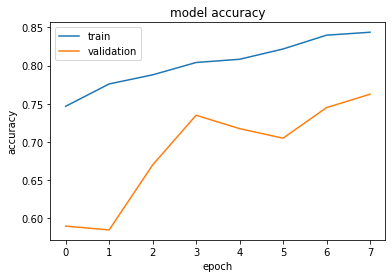

In [19]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

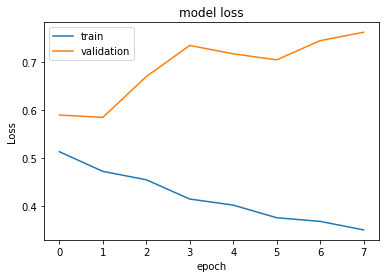

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_accuracy"])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [21]:
#how this model performs after fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

25/25 [==============================] - 91s 4s/step - loss: 0.5155 - accuracy: 0.7625


[0.5154600739479065, 0.762499988079071]

In [ ]:

test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

16/20 [=======================>......] - ETA: 1:11

In [ ]:
labels_pred=np.where(pred > 0.5, 1, 0)

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(5):
    image = x[i]
    plt.title('Predicted Label: ' + str(labels_pred[i]))
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [ ]:
import sklearn
acc=sklearn.metrics.accuracy_score(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Accuracy: \n' + str(acc))

In [ ]:
confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Confusion Matrix: \n' + str(confusion_matrix))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(),labels_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score: ' + str(roc_auc))

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='EfficientNet B3')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
jac=sklearn.metrics.jaccard_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('Jaccard Score: ' + str(jac))

In [ ]:
model.save("EfficientNetB3_sigmoid.h5")
print("Saved model to disk")

# load model
#model = tf.keras.models.load_model('EfficientNetB3_sigmoid.h5')
#model.summary()